In [1]:
#import numpy as np
import torch
from typing import Tuple, List, Optional

In [2]:
import matplotlib.pyplot as plt
plt.style.use('bmh')

In [3]:
import os 
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from datagen_temporal import _generate_DGP, _generate_U, _generate_V            # noqa: E402

In [4]:
t = 50
r = 9
m = 25

In [5]:
#vcovsU, V = _generate_DGP(t = t, m = m, r = r, kernel= 'matern', vtype='random')

In [6]:
vcovsU, V = _generate_DGP(t = t, m = m, r = r, kernel= 'cauchy', vtype='random')

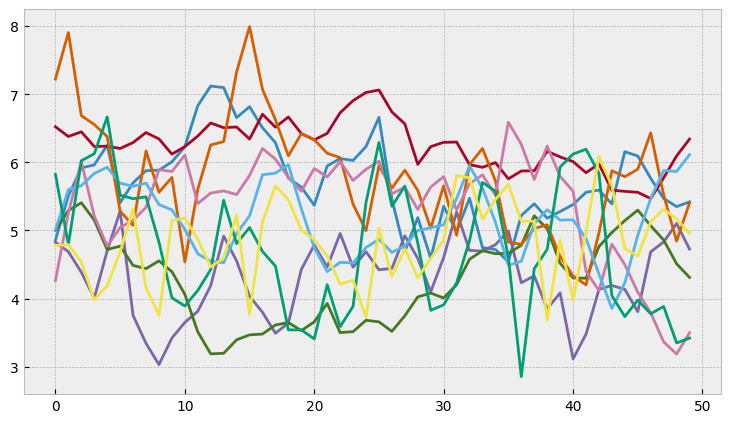

In [7]:
U = _generate_U(vcovsU)
# Plot each column as a line graph
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
for col in range(r):
    ax.plot(U[:, col], label='U_{}'.format(col))
    #ax.legend()
plt.show()

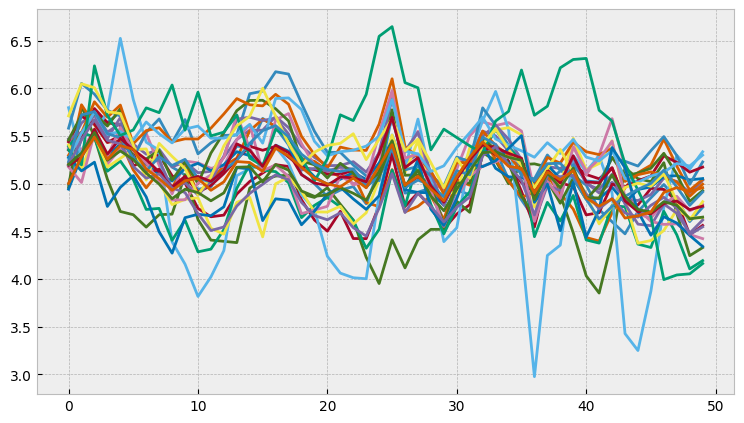

In [8]:
M = U @ V.T

fig, ax = plt.subplots(1, 1, figsize=(9, 5))
for col in range(m):
    ax.plot(M[:, col])
plt.show()

In [9]:
# assume each column is a price time series -- compute returns
def fin_return(val_start, val_end):
    return (val_end - val_start) / val_start

# generate a new matrix of returns with one fewer row than M
M_rets = fin_return(M[:-1, :], M[1:, :])

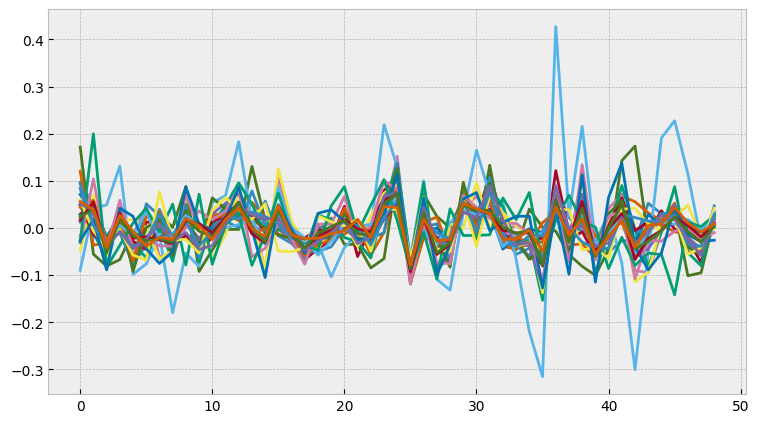

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
for col in range(m):
    ax.plot(M_rets[:, col])
plt.show()

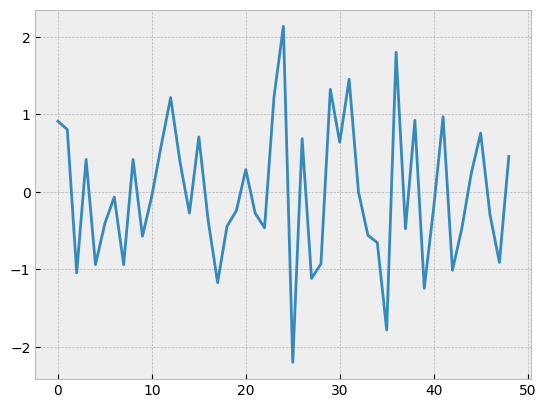

In [11]:
plt.plot(M_rets.sum(dim = 1))

In [ ]:
t = 30
r = 9
m = 15
realizations = 10

vcovsU, V = _generate_DGP(t = t, m = m, r = r)
Us = torch.zeros((realizations, t, r))
for i in range(realizations):
    Us[i] = _generate_U(vcovsU)
Us.shape

torch.Size([10, 30, 9])

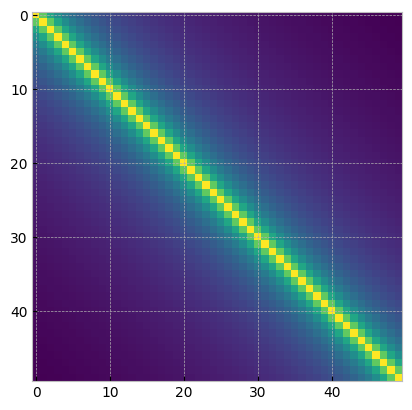

In [ ]:
plt.imshow(vcovsU[2])